In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install umap-learn

     |████████████████████████████████| 81kB 3.3MB/s 
     |████████████████████████████████| 1.2MB 8.7MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=d2d6b45b610b87b3a5a27a23ee1a571b1d12a26deee10bc65e9e3ae93bf0b658
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=51351 sha256=837f2975bf950f634102fa22f2ce444fc8098123478d5d3f872eddd1cda14f93
  Stored in directory: /root/.cache/pip/wheels/ba/52/4e/4c28d04d144a28f89e2575fb63628df6e6d49b56c5ddd0c74e
Successfully built umap-learn pynndescent


In [5]:
import warnings
import re
from PIL import Image
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numba


%matplotlib inline

In [6]:
# movie titles
mv_genres = pd.read_csv("/content/drive/MyDrive/ml-20m/ml-20m/movies.csv")

In [7]:
# movie tags
mv_tags = pd.read_csv("/content/drive/MyDrive/ml-20m/ml-20m/genome-scores.csv")

In [8]:
# movie tag descriptions
mv_tags_desc = pd.read_csv("/content/drive/MyDrive/ml-20m/ml-20m/genome-tags.csv")

In [9]:
# clean title in movies.csv file

def movie_title_clean(title):
    
    #     search title for (year) pattern
    s = re.search('\(([^)]+)', title)
    # if pattern exists, remove from string
    year = 9999
    if s:
        title = title[:s.span()[0]].strip()
        year = s.group(1)

    #     check if year is actual year
    if str(year).isdigit():
        year = int(year)
    else:
        year = 9999
    
# if ', The' or ', A' is a the end of the string, move it to the front
  # e.g. change "Illusionist, The" to "The Illusionist"
    
    if title[-5:] == ', The':
        title = 'The ' + title[:-5]
    elif title[-4:] == ', An':
        title = 'An ' + title[:-4]
    elif title[-3:] == ', A':
        title = 'A ' + title[:-3]

    return title, year

In [10]:
# clean title and extract release year
mv_genres["title"] = mv_genres["title"].str.strip()
mv_genres["Title_Year"] = mv_genres["title"].map(movie_title_clean)
mv_genres["Title"] = mv_genres["Title_Year"].apply(lambda x: x[0])
mv_genres["Release Year"] = mv_genres["Title_Year"].apply(lambda x: x[1])

In [11]:
mv_genres.head()

,movieId,title,genres,Title_Year,Title,Release Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,"(Jumanji, 1995)",Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,"(Grumpier Old Men, 1995)",Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,"(Father of the Bride Part II, 1995)",Father of the Bride Part II,1995


In [12]:
# create binary indicators for each genre

mv_genres_stack = mv_genres[mv_genres["genres"] != "(no genres listed)"].set_index("movieId").genres.str.split("|", expand = True).stack()
mv_genres_explode = pd.get_dummies(mv_genres_stack, prefix="g").groupby(level=0).sum().reset_index()
del mv_genres_stack

In [13]:
# genre vector (binary string)
mv_genres_explode["genre_vector"] = mv_genres_explode.iloc[:, 1:].values.tolist()

In [14]:
# check out genre vector
mv_genres_explode.head()

,movieId,g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Fantasy,g_Film-Noir,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western,genre_vector
0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [15]:
# append genre vector
mv_genres = mv_genres.merge(mv_genres_explode[['movieId','genre_vector']], on = 'movieId', how = 'left')

In [16]:
# check out genre dataframe with genre vector
mv_genres.head()

,movieId,title,genres,Title_Year,Title,Release Year,genre_vector
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",Toy Story,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"(Jumanji, 1995)",Jumanji,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"(Grumpier Old Men, 1995)",Grumpier Old Men,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",Waiting to Exhale,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
4,5,Father of the Bride Part II (1995),Comedy,"(Father of the Bride Part II, 1995)",Father of the Bride Part II,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [17]:
# How many tags do we need or each movie??

In [18]:
# nmber of tags
len(np.unique(mv_tags_desc.tagId.values))

1128

In [19]:
# number of movies
len(np.unique(mv_tags.movieId.values))

10381

In [20]:
# number of movie, tag pairs
len(mv_tags)

11709768

In [21]:
# join dataframes to get tag description and movie title name all in one table
mv_tags_denorm = mv_tags.merge(mv_tags_desc, on = 'tagId').merge(mv_genres, on = 'movieId')

# for each movie, compute the relevance rank of tags so we can eventually rank order tags for each movie
mv_tags_denorm['relevance_rank'] = mv_tags_denorm.groupby("movieId")["relevance"].rank(method = "first", ascending = False).astype('int64')

In [22]:
# check out an example of top tags for a movie
mv_tags_denorm[mv_tags_denorm.Title == 'Remember the Titans'][['movieId','Title','tag','relevance','relevance_rank']].sort_values(by = 'relevance', ascending = False).head(10)

,movieId,Title,tag,relevance,relevance_rank
3896511,3916,Remember the Titans,football,0.99600,1
3897070,3916,Remember the Titans,sports,0.98600,2
3896944,3916,Remember the Titans,race issues,0.97625,3
3896498,3916,Remember the Titans,feel good movie,0.96200,4
3896226,3916,Remember the Titans,based on true story,0.95175,5
3896499,3916,Remember the Titans,feel-good,0.94825,6
3896221,3916,Remember the Titans,based on a true story,0.93975,7
3896660,3916,Remember the Titans,inspiring,0.93650,8
3896614,3916,Remember the Titans,high school,0.93025,9
3896659,3916,Remember the Titans,inspirational,0.92550,10


In [23]:
# compute median relevance score for each relevance rank
mv_tags_rank_agg = mv_tags_denorm.groupby('relevance_rank')['relevance'].median().reset_index(name = 'relevance_median').head(100)

# compute percent change of median relevance score as we go down in rank
mv_tags_rank_agg['relevance_median_pct_chg'] = mv_tags_rank_agg['relevance_median'].pct_change()

Text(0.5, 1.0, 'Box Plot: Tag Relevance Score by Rank')

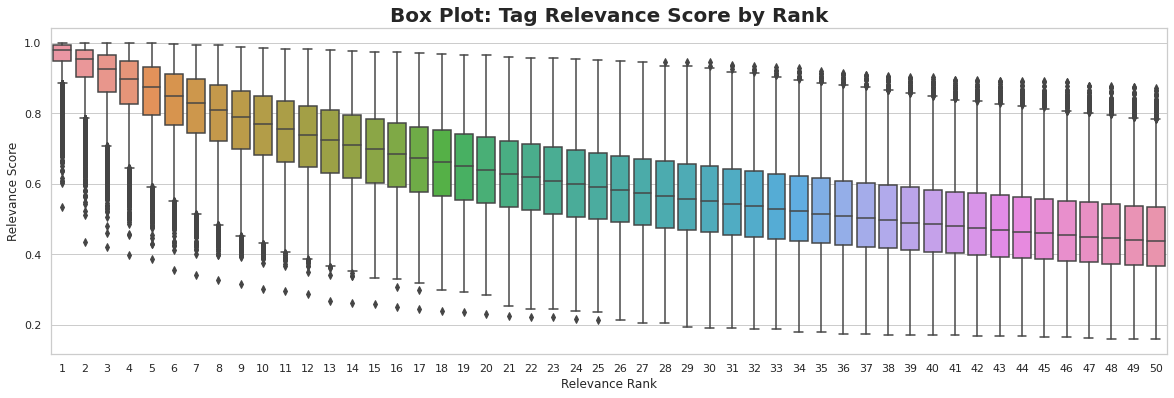

In [24]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(20, 6))

ax = sns.boxplot(x = "relevance_rank", y = "relevance", data = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 50], showfliers = True)
ax.set(ylabel = "Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("Box Plot: Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')

Text(0.5, 1.0, '% Change in Tag Relevance Score by Rank')

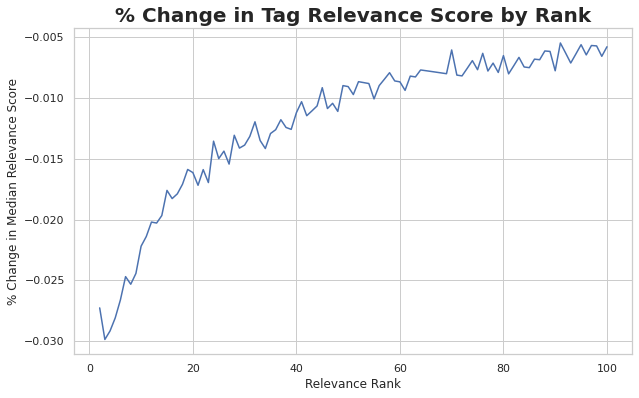

In [25]:
f, ax = plt.subplots(figsize=(10, 6))

ax = sns.lineplot(x="relevance_rank", y="relevance_median_pct_chg", data = mv_tags_rank_agg)
ax.set(ylabel = "% Change in Median Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("% Change in Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')

In [26]:
# flatten tags table to get a list of top 100 tags for each movie
mv_tags_list = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 100].groupby(['movieId','Title'])['tag'].apply(lambda x: ','.join(x)).reset_index()
mv_tags_list['tag_list'] = mv_tags_list.tag.map(lambda x: x.split(','))

In [27]:
mv_tags_list.head(1)

,movieId,Title,tag,tag_list
0,1,Toy Story,"3d,action,adventure,affectionate,animal movie,...","[3d, action, adventure, affectionate, animal m..."


In [28]:
# compute Jaccard Index to get most similar movies to target movie

pd.reset_option('display.max_colwidth')

target_movie = 'Interstellar'

target_tag_list = mv_tags_list[mv_tags_list.Title == target_movie].tag_list.values[0]
mv_tags_list_sim = mv_tags_list[['movieId','Title','tag_list','tag']]
mv_tags_list_sim['jaccard_sim'] = mv_tags_list_sim.tag_list.map(lambda x: len(set(x).intersection(set(target_tag_list))) / len(set(x).union(set(target_tag_list))))
print(f'Movies most similar to {target_movie} based on tags:')
text = ','.join(mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(25)['tag'].values)
mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(10)

Movies most similar to Interstellar based on tags:


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,movieId,Title,tag_list,tag,jaccard_sim
10046,109487,Interstellar,"[70mm, adventure, amazing cinematography, amaz...","70mm,adventure,amazing cinematography,amazing ...",1.000000
8055,52328,Sunshine,"[alien, aliens, allegory, amazing cinematograp...","alien,aliens,allegory,amazing cinematography,a...",0.503759
9803,101864,Oblivion,"[action, adapted from:comic, adventure, alien,...","action,adapted from:comic,adventure,alien,alie...",0.503759
9915,104841,Gravity,"[3d, action, allegory, amazing cinematography,...","3d,action,allegory,amazing cinematography,amaz...",0.470588
1452,1653,Gattaca,"[allegory, alone in the world, amazing cinemat...","allegory,alone in the world,amazing cinematogr...",0.459854
1390,1584,Contact,"[adapted from:book, adventure, alien, alien in...","adapted from:book,adventure,alien,alien invasi...",0.459854
10220,114935,Predestination,"[absurd, adaptation, allegory, alternate endin...","absurd,adaptation,allegory,alternate endings,a...",0.449275
9676,97752,Cloud Atlas,"[1930s, 19th century, adaptation, adapted from...","1930s,19th century,adaptation,adapted from:boo...",0.428571
3864,4370,A.I. Artificial Intelligence,"[adventure, alien, aliens, allegory, alone in ...","adventure,alien,aliens,allegory,alone in the w...",0.428571
8696,68237,Moon,"[androids, artificial intelligence, astronauts...","androids,artificial intelligence,astronauts,at...",0.428571


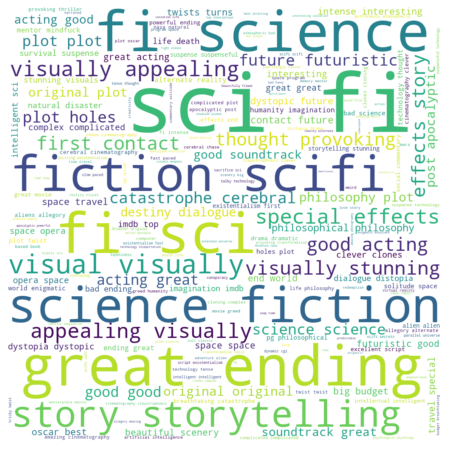

In [29]:
plt.rcParams["figure.figsize"] = (15,10)

# Generate a word cloud image
wordcloud = WordCloud(width = 1024, height = 1024, background_color = 'white').generate(text)

# Display the generated image:
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [30]:
# corpus of movie tags
mv_tags_corpus = mv_tags_list.tag.values

In [32]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [37]:
stop_words = stopwords.words('english')

# tokenize document and clean
def word_tokenize_clean(doc):
  
  # split into lower case word tokens
  tokens = word_tokenize(doc.lower())
  
  # remove tokens that are not alphabetic (including punctuation) and not a stop word
  tokens = [word for word in tokens if word.isalpha() and not word in stop_words]
  
  return tokens

In [38]:
# preprocess corpus of movie tags before feeding it into Doc2Vec model
mv_tags_doc = [TaggedDocument(words=word_tokenize_clean(D), tags=[str(i)]) for i, D in enumerate(mv_tags_corpus)]

In [39]:
# instantiate Doc2Vec model

max_epochs = 50
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,
               alpha=alpha, min_alpha=0.00025,
               min_count=1, dm=0) #paragraph vector distributor

model.build_vocab(mv_tags_doc)

/usr/local/lib/python3.7/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [40]:
#  train Doc2Vec model
# stochastic (random initialization), so each run will be different unless you specify seed

print('Epoch', end = ': ')
for epoch in range(max_epochs):
  print(epoch, end = ' ')
  model.train(mv_tags_doc,
              total_examples=model.corpus_count,
              epochs=model.epochs)
  # decrease the learning rate
  model.alpha -= 0.0002
  # fix the learning rate, no decay
  model.min_alpha = model.alpha

Epoch: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [41]:
# listing space embeddings
mv_tags_vectors = model.docvecs.vectors_docs

In [42]:
mv_tags_vectors.shape

(10381, 20)

In [43]:
# top similar movies based on cosine similarity

mv = 'Good Will Hunting'

mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]

print(mv_tags_vectors[mv_index])

sims = model.docvecs.most_similar(positive = [mv_index], topn = 30)

for i, j in sims:
  print(mv_tags_list.loc[int(i), "Title"].strip())

[-0.78866243  0.437322    0.7820136   0.5351759  -0.3895694  -1.3417495
 -0.41982982 -1.0514369   0.50239575 -0.7018111  -1.474787    0.56047344
  0.04812603 -0.15781604  0.37720343  0.79990876 -0.20894542  1.6242871
  2.0441837  -0.13755655]
As Good as It Gets
Dead Poets Society
Children of a Lesser God
The Big Chill
On Golden Pond
Scent of a Woman
Finding Forrester
The Theory of Everything
The Shawshank Redemption
Barney's Version
The Sea Inside
St. Vincent
Sideways
Dallas Buyers Club
Ruby Sparks
Starting Out in the Evening
The Hustler
Rain Man
Me and Orson Welles
Cinema Paradiso
Midnight Cowboy
American Beauty
The Apartment
Moneyball
The Paper Chase
Beautiful Girls
Grand Hotel
Return to Paradise
Annie Hall
One Flew Over the Cuckoo's Nest


In [45]:


# dimensionality reduction to 2D
mv_tags_vectors_umap = umap.UMAP(n_neighbors = 5,
                          min_dist = 0.001,
                          metric = 'cosine').fit_transform(mv_tags_vectors)



In [46]:
x, y = mv_tags_vectors_umap.T[0], mv_tags_vectors_umap.T[1]

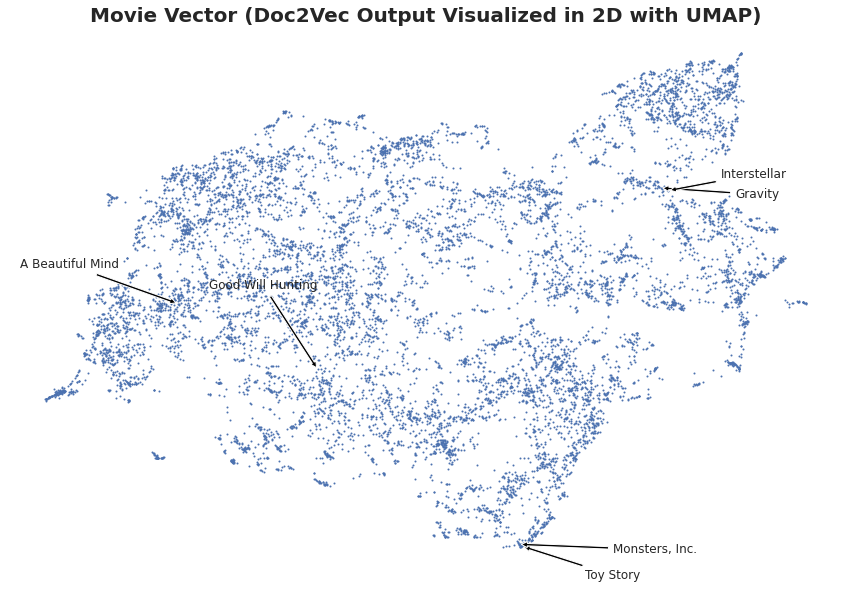

In [47]:


# visualize movie vectors in 2D with UMAP
# label some movies

plt.rcParams["figure.figsize"] = (15,10)
plt.grid(b = None)
plt.axis('off')
plt.scatter(x, y, s = 1)
plt.title('Document Embedding (UMAP)')
plt.xlabel('e1')
plt.ylabel('e2')

mv = 'A Beautiful Mind'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]-1, mv_tags_vectors_umap[mv_index, 1]+1),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Good Will Hunting'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]+2),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Gravity'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Interstellar'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]+0.5),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Toy Story'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]-0.5),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'Monsters, Inc.'
mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+3, mv_tags_vectors_umap[mv_index, 1]+0.025),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

plt.title('Movie Vector (Doc2Vec Output Visualized in 2D with UMAP)', fontsize = 20, weight = 'bold')
plt.show()



In [48]:
# history of movies the user watched and liked
user_movies = ['Interstellar','Good Will Hunting','Gattaca',
               'Almost Famous','The Shawshank Redemption','Edge of Tomorrow',
               'Jerry Maguire','Forrest Gump','Back to the Future']

# compute user vector as an average of movie vectors seen by that user
user_movie_vector = np.zeros(shape = mv_tags_vectors.shape[1])
for mv in user_movies:
  mv_index = mv_tags_list[mv_tags_list["Title"] == mv].index.values[0]  
  user_movie_vector += mv_tags_vectors[mv_index]

user_movie_vector /= len(user_movies)  

# print(user_movie_vector)
  
#  find movies similar to user vector to generate movie recommendations

print('Movie Recommendations:')

sims = model.docvecs.most_similar(positive = [user_movie_vector], topn = 30)

for i, j in sims:
  movie_sim = mv_tags_list.loc[int(i), "Title"].strip()
  if movie_sim not in user_movies:
    print(movie_sim)

Movie Recommendations:
The Theory of Everything
Dead Poets Society
Cast Away
Charly
Mr. Holland's Opus
Rain Man
Children of a Lesser God
On Golden Pond
Star Trek: First Contact
A Beautiful Mind
The Curious Case of Benjamin Button
Groundhog Day
It's a Wonderful Life
Pay It Forward
Contact
E.T. the Extra-Terrestrial
The Aviator
Up in the Air
Her
The Natural
Life Itself
Taps
Gravity
A Brief History of Time
